# Produce IRF from test MC DL2 (all-sky MC production) with `lstchain_create_irf_files`

Create instrument response functions (IRF) in FITS format, from **test MC DL2** files assuming certain **selection cuts and event filtering** using the `lstchain_create_irf_files` Tool, which in turn uses [**pyirf**](https://pyirf.readthedocs.io).

Its usage and input arguments are described in the `--help` docstring (`--help-all` for a more detailed description of all the input arguments):
```
$ lstchain_create_irf_files --help
```

This notebook explains how to produce a **[point-like IRF](https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/point_like/index.html)** needed to perform a 1D analysis with Gammapy, from gamma-ray *testing* MC DL2 files.

As a reminder, here is the overall view of the MC products from [**lstmcpipe**](https://cta-observatory.github.io/lstmcpipe/pipeline.html). The standard DL1/DL2 MC files are separated as *testing* and *training* files, where the DL1 *training* files are used to train the Random Forest models for the reconstruction of DL1 files to DL2, and DL2 *testing* files are used for producing the IRFs, which, together with the gamma-ray-like selected event list, comprise the DL3, the science-ready data products.

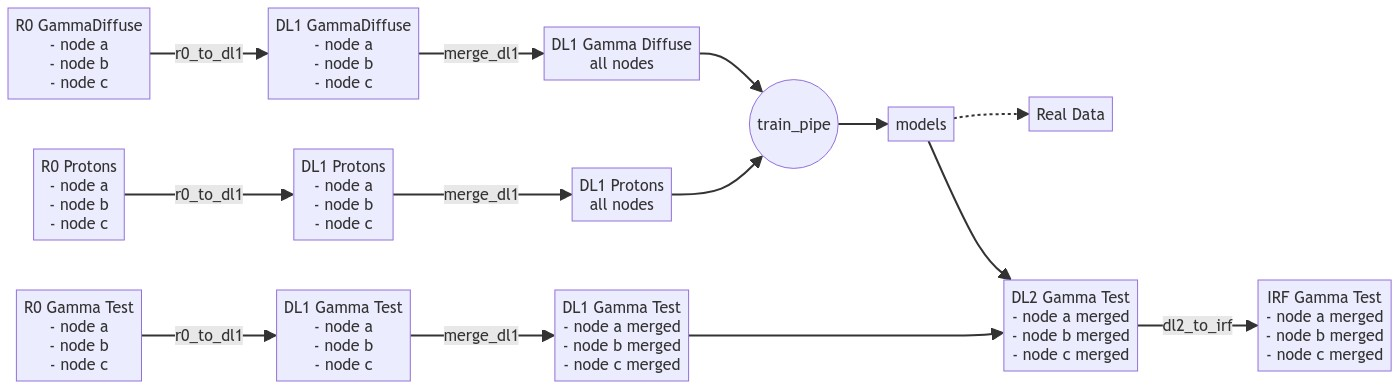


The training/testing MC samples are produced in discrete sky-pointing directions across the whole sky:
 - Training MC pointing nodes (circle markers) are produced along several declination lines.
 - Testing MC nodes are produced in a regular triangular grid in cos(zenith angle) and B⊥/B (star markers).

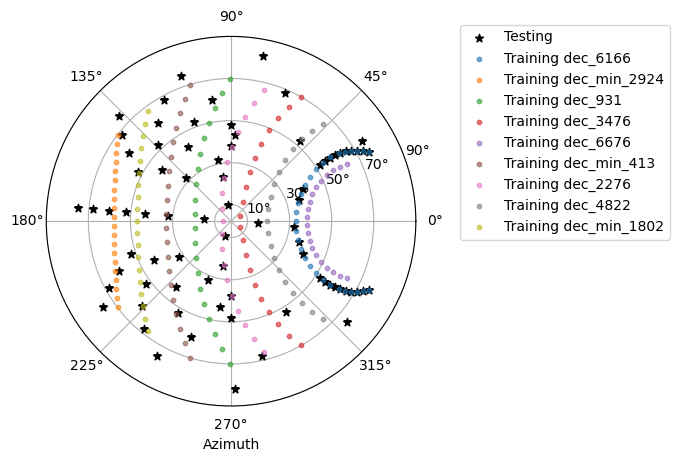

In this notebook, we calculate the IRF for each of these testing MC nodes. Then, **for any telescope pointing, the IRFs are interpolated**, a step that is done later by the `lstchain_create_dl3_file` Tool (for lstchain > v0.10.x).

For the **selection of the gamma-like events** that are going to be used for the IRF calculation, there is a first selection based on certain filters (e.g. minimum intensity value), and later a set of selection cuts on *gammaness* and *theta*/*alpha*, which can be either fixed global cuts or energy-dependent cuts with a certain gamma-ray efficiency and containment region. **Important:** The same selection cuts should be used for the DL3 gamma-like event list production.

For the use of the Tool, we also need a **config file providing the event selection cuts and binning information**. One can use the example config file available in [`cta-lstchain/docs/examples/irf_dl3_tool_config.json`](https://github.com/cta-observatory/cta-lstchain/blob/main/docs/examples/irf_dl3_tool_config.json) or create a similar config file for each specific use case. If the config file is not provided, the default values are used as per the Component in the file `cta-lstchain/lstchain/io/event_selection.py`.

**Warning:** The production of *[full-enclosure IRF](https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/full_enclosure/index.html#full-enclosure-irfs)* is also possible with this tool but we need diffuse gamma-ray MC DL2 (not being generated currently in the all-sky MC standard production). Also, background IRF may be calculated if proton and electron MC are provided. These two cases are not covered in this notebook.

In [ ]:
%matplotlib inline
from astropy.io import fits
import astropy.units as u
from astropy.table import QTable

import matplotlib.pyplot as plt
from traitlets.config.loader import Config

from gammapy.irf import EnergyDispersion2D, EffectiveAreaTable2D
from lstchain.io.config import read_configuration_file
from pathlib import Path
import subprocess

# Settings of the tool (defined by the user)

## Input files: standard all-sky DL2 test MC
It is in: `/fefs/aswg/data/mc/DL2/AllSky` where you can see all the available productions.

**Important:** You should use v0.10* productions if you are using lstchain v0.10*, v0.9 MC productions cannot be analyzed with lstchain v0.10

In [ ]:
# Use standard all-sky MC files
mc_base_dir = Path("/fefs/aswg/data/mc/DL2/AllSky")

For this example, let's use one of the latest all-sky base productions:
`20230901_v0.10.4_allsky_base_prod` (it is recommended to use the latest one available).

Each production has at least one directory indicating the declination line. In this case, we use `dec_2276` (declination line close to the Crab) so the full path would be:
```
/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_2276
```
Finally, inside this directory, you will find multiple subfolders corresponding to each simulated pointing node with a merged test gamma DL2 MC file (see the all-sky plot at the beginning of this notebook).

We will produce IRF files from each of these DL2 files for all the nodes and store them in a directory for later use by the DL3 Tool.

In [ ]:
# Directory containing all the nodes subfolders
mc_prod = "20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_2276"
dl2_test_mc_dir = mc_base_dir / mc_prod 

## Output: directory for IRF files
### USERS: if you want to run this example notebook set an output directory `irf_output_dir` where you have write access.

In [ ]:
# Define the output directory to store the produced IRFs node-wise
irf_output_dir = Path("/fefs/aswg/workspace/analysis-school-2024/DL2_to_DL3/IRF")
irf_log = irf_output_dir / "log"
# Create directory including all parents if they do not exist
irf_log.mkdir(exist_ok=True, parents=True)

By default, `lstchain_create_irf_files` assumes global cuts in gammaness and theta. 

However, for computing the spectrum and light curve, it is recommended to use energy-dependent cuts based on a certain gamma-ray selection cut efficiency (activating the flags `--energy-dependent-gh` and `--energy-dependent-theta`). These dynamic cuts are calculated from the gamma-ray DL2 MC in each bin of reconstructed energy (keeping the wanted percentage of gamma-ray-like events in each energy bin with the highest gammaness and lowest theta values).

Input arguments can be specified by the command line or config file. Let's assume the ones defined in the example config file for this demonstration.

**Warning:** Setting the parameters via the command line overrides the settings in the config file.

## Standard settings

For most cases doing a standard analysis, it is recommended not to modify any parameter other than the efficiency value of the gammaness and theta cuts.

 - The global cut of intensity > 50 p.e. ensures a good match between the data and MC (for data
taken after 2021 August). This global cut brings all of the data to a common *analysis threshold*.
 - In principle, there is no need to apply any other event filtering based on image parameters. We will use **gammaness and theta energy-dependent cuts**.
 - The **standard values are 70% selection efficiency for both gammaness and theta**, which are the ones used for the baseline analysis in the Crab performance paper ([H. Abe et al 2023 ApJ 956 80](https://iopscience.iop.org/article/10.3847/1538-4357/ace89d)). To enable these efficiency cuts, you have to pass via command line the options `--energy-dependent-gh` and `--energy-dependent-theta` respectively. The efficiency values can be either passed via command line or just set them in the config file `irf_dl3_tool_config.json`.
 - The rest of the configuration file can be left untouched.

In [ ]:
irf_config_file = "/fefs/aswg/workspace/analysis-school-2024/cta-lstchain/docs/examples/irf_dl3_tool_config.json" 
config = Config(read_configuration_file(irf_config_file))
config

# Running the tool

For example, the way of running the IRF creation tool for a given DL2 testing MC file is:

```
$lstchain_create_irf_files \
 --point-like \
 --input-gamma-dl2=/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_2276/node_theta_32.059_az_248.099_/dl2_20230901_v0.10.4_allsky_base_prod_node_theta_32.059_az_248.099__merged.h5 \
 --output-irf-file=/fefs/aswg/workspace/analysis-school-2024/DL2_to_DL3/IRF/irf_node_theta_32.059_az_248.099_.fits.gz \
 --config=/fefs/aswg/workspace/analysis-school-2024/cta-lstchain/docs/examples/irf_dl3_tool_config.json \
 --log-file=/fefs/aswg/workspace/analysis-school-2024/DL2_to_DL3/IRF/log/irf_node_theta_32.059_az_248.099_.fits.log \
 --energy-dependent-gh \
 --energy-dependent-theta \
 --overwrite
```

This will apply the energy-dependent cuts with the efficiency indicated in `irf_dl3_tool_config.json` above. It does not matter if other settings/parameters are present. E.g. those related to *alpha*, or to the global cuts, they are simply ignored.

# Example of running the tool in parallel for each MC node using SLURM
The production of each IRF usually takes around 1 min. Here we submit all jobs so they are produced in parallel.

In [ ]:
# Loop over the nodes inside each MC declination-line test DL2 directory
# to create an IRF file for each MC node and a given value of gammaness efficiency and theta containment

nodes = dl2_test_mc_dir.glob("node_*")

log_dir = irf_output_dir / "log"
log_dir.mkdir(exist_ok=True, parents=True)

for node in nodes:

    try:  # Look for the DL2 test MC file
        dl2_mc_gamma = next(node.glob("dl2_*__merged.h5"))
    except StopIteration:
        log.warning(f"Missing DL2 MC file in {node.name}")

    # We include the node in the filename to differentiate between IRF files
    irf_file = irf_output_dir / f"irf_{node.name}.fits.gz"
    log_file = log_dir / f"{irf_file.stem}.log"
    
    sbatch_cmd = [
        "sbatch",
        "--mem-per-cpu=12GB"
    ]
    
    lstchain_cmd = [
        "lstchain_create_irf_files",
        "--point-like",
        f"--input-gamma-dl2={dl2_mc_gamma}",
        f"--output-irf-file={irf_file}",
        f"--config={irf_config_file}",
        f"--log-file={log_file}",
        "--energy-dependent-gh",
        "--energy-dependent-theta",
        "--overwrite",
    ]

    # print(" \\\n ".join(lstchain_cmd))  # If you want to check how the actual command looks
    # subprocess.run(sbatch_cmd + lstchain_cmd)  # Uncomment this line, but be careful! This will submit tens of jobs





# Check the point-like IRFs with some basic plots
Let's have a look at one of these IRF files using Astropy and Gammapy:

In [ ]:
irf_file = Path("/fefs/aswg/workspace/analysis-school-2024/DL2_to_DL3/IRF/irf_node_theta_32.059_az_248.099_.fits.gz")

In [ ]:
fits.open(irf_file).info()

In [ ]:
aeff = EffectiveAreaTable2D.read(irf_file, hdu="EFFECTIVE AREA")
edisp = EnergyDispersion2D.read(irf_file, hdu="ENERGY DISPERSION")

# Since we have use energy-dependent gh and theta cuts:
gh_cut = QTable.read(irf_file, hdu="GH_CUTS")
theta_cut = QTable.read(irf_file, hdu="RAD_MAX")

The headers of these tables indicate the applied efficiency for the cuts in gammaness and theta.

In [ ]:
# Example header information for IRFs
fits.open(irf_file)["EFFECTIVE AREA"].header

In this case 70% and 70% for both gammaness and theta angular cut:

```
GH_EFF  =                  0.7 / gamma/hadron efficiency                        
TH_CONT =                  0.7 / Theta containment region in percentage
```

Instead, if you would have used **global cuts**, the keywords would be `GH_CUT` and `RAD_MAX`, indicating the values of the cuts:

```
GH_CUT  =                  0.7                                                  
RAD_MAX =                  0.2 / deg   
```

# Effective area

In [ ]:
# Effective Area energy dependence

plt.figure()
aeff.plot_energy_dependence(offset=[0.4 * u.deg])
plt.legend().remove()
plt.yscale('log')
plt.grid(which='both')

# Energy dispersion and energy bias

In [ ]:
# Energy Dispersion, energy migration
plt.figure(figsize=(12,10))

offset = "0.4 deg"
true_energy = [0.1, 0.5, 1, 10] * u.TeV

plt.subplot(221)
edisp.plot_migration(offset=offset, energy_true=true_energy[0])
plt.legend(loc=1)
plt.grid()

plt.subplot(222)
edisp.plot_migration(offset=offset, energy_true=true_energy[1])
plt.legend(loc=1)
plt.grid()

plt.subplot(223)
edisp.plot_migration(offset=offset, energy_true=true_energy[2])
plt.legend(loc=1)
plt.grid()

plt.subplot(224)
edisp.plot_migration(offset=offset, energy_true=true_energy[3])
plt.legend(loc=1)
plt.grid()

plt.suptitle("Energy migration")

In [ ]:
# Energy bias

plt.figure(figsize=(12, 4))

plt.subplot(121)
edisp.plot_bias(offset=offset, add_cbar=True)
plt.title("Energy Bias")

plt.subplot(122)
edisp_kernel = edisp.to_edisp_kernel(offset=0.4*u.deg)
edisp_kernel.plot_bias()
plt.grid()
plt.title("Energy Bias at 0.4 deg");

In [ ]:
# Energy migration matrix
edisp_kernel.plot_matrix(add_cbar=True)
plt.title("Energy Migration Matrix")

# Energy-dependent gammaness cuts

In [ ]:
gh_cut.meta 

In [ ]:
plt.figure()

plt.errorbar(
    gh_cut["center"], gh_cut["cut"],
    xerr=(
        gh_cut["center"] - gh_cut["low"], 
        gh_cut["high"] - gh_cut["center"]
    )
)

plt.xscale('log')
plt.title(r"$\gamma$/h cuts distribution")
plt.ylabel(r'$\gamma$/h cut')
plt.xlabel('Energy [TeV]')
plt.grid(which='both')

# Energy-dependent theta cuts

In [ ]:
theta_cut.meta

In [ ]:
plt.figure()
plt.errorbar(
    0.5 * (theta_cut[0]['ENERG_LO'] + theta_cut[0]['ENERG_HI'])[1:-1],
    theta_cut[0]['RAD_MAX'].T[1:-1, 0],
    xerr=0.5 * (theta_cut[0]['ENERG_HI'] - theta_cut[0]['ENERG_LO'])[1:-1]
)
plt.xscale('log')
plt.title("Theta cuts distribution")
plt.ylabel('Theta cut')
plt.xlabel('Log Energy [TeV]')
plt.grid(which='both')

# Next step (DL2 to DL3): 
Use all these IRF files and the observed DL2 data to produce DL3 files using IRF interpolation with the Tool `lstchain_create_dl3_file`
(see [DL2_to_DL3.ipynb](https://github.com/cta-observatory/cta-lstchain/blob/main/notebooks/DL2_to_DL3.ipynb))

In case you are not using IRF interpolation (not recommended), for each data run you should use the IRF file from the nearest test MC node.
Before v0.10 the step of looking for the nearest node to the average telescope pointing of each data run was not standardized. 

As of lstchain v0.10, although the IRF interpolation is recommended, it is also possible to use just the nearest node IRF for each run
by using the `--use-nearest-irf-node` flag in `lstchain_create_dl3_file`. The tool automatically searches for the nearest MC node to the observed data run and uses it.

In case you have to analyze v0.9 observed data you can use lstchain v0.10 for the analysis, and v0.10
versions of the MC products (RF models and DL2), thus taking advantage of the IRF interpolation.
There is no significant difference in the DL1 products created with v0.9 and v0.10.